In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import time

# this is algo
from src.algo_stm import STM_Method
from src.rosenbrock import optimize_rosenbrock
from src.rosenbrock import rosenbrock
from src.degenerate_nesterov import degenerate_nesterov
from src.optimize_func import optimize
from src.optimize_func import plot_path


### Try with Rosenbrock function

tensor(-12.4937, dtype=torch.float64)


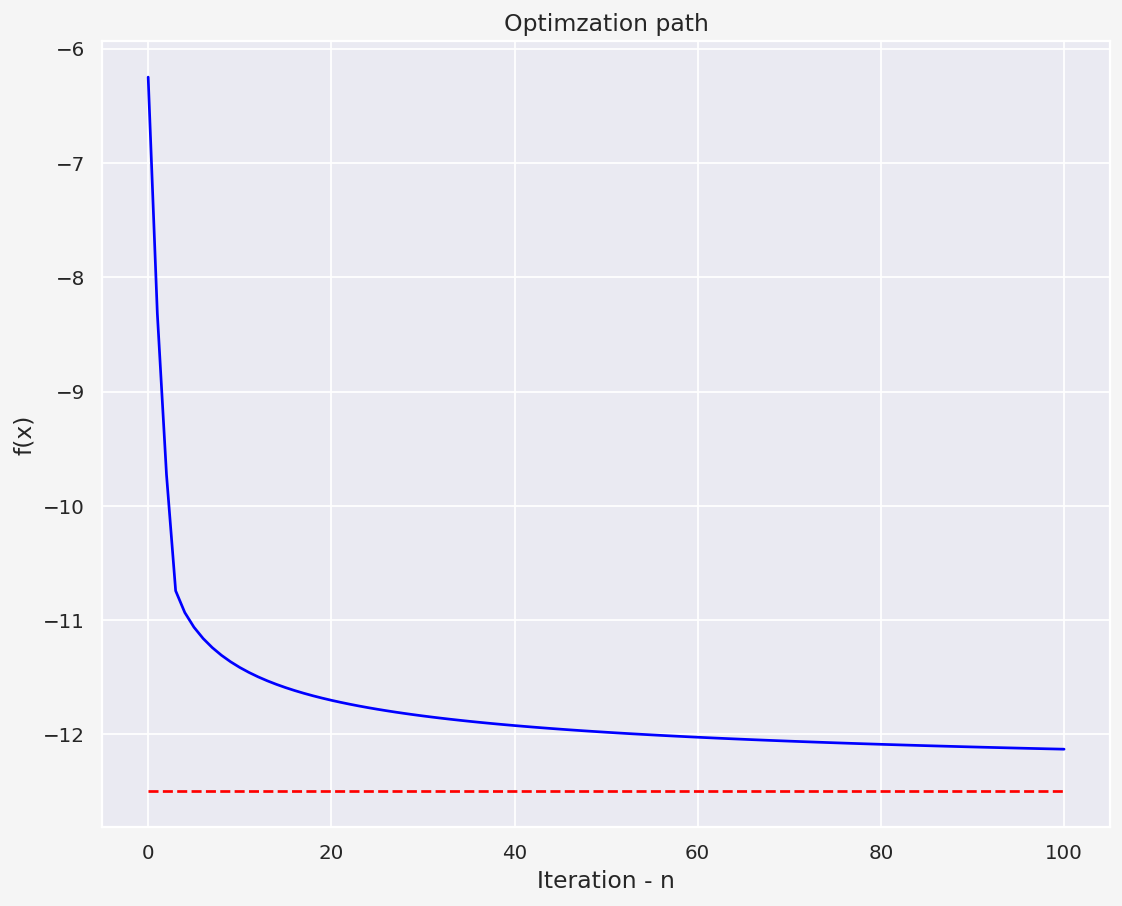

In [5]:
dim = 2000
start = np.ones(dim) * 0.5
min_point = np.zeros(dim)
k = (dim - 1) // 2
for i in range(2 * k + 2):
    min_point[i] = 1 - (i / (2 * k + 2))
min_value = degenerate_nesterov(torch.tensor(min_point), Lipsitz=100)
print(min_value)
path = optimize(degenerate_nesterov, start_point=start, iterations=100, optim=STM_Method, L=100)
plot_path(path, degenerate_nesterov, Lipsitz=100, min_value=min_value)

In [6]:
def sumq(xy):
    return xy[0] ** 2 + xy[1] ** 2

def func(start_point, optim, iterations: int, **optimizer_kwargs):

    xy = torch.tensor(start_point, requires_grad=True)
    optimizer = optim([xy], **optimizer_kwargs)

    path = np.empty((iterations + 1, 2))
    path[0] = start_point

    for iteration in range(1, iterations):
        optimizer.zero_grad()
        loss = sumq(xy)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(xy, 1)
        optimizer.step()

        path[iteration] = xy.data
    
    return path

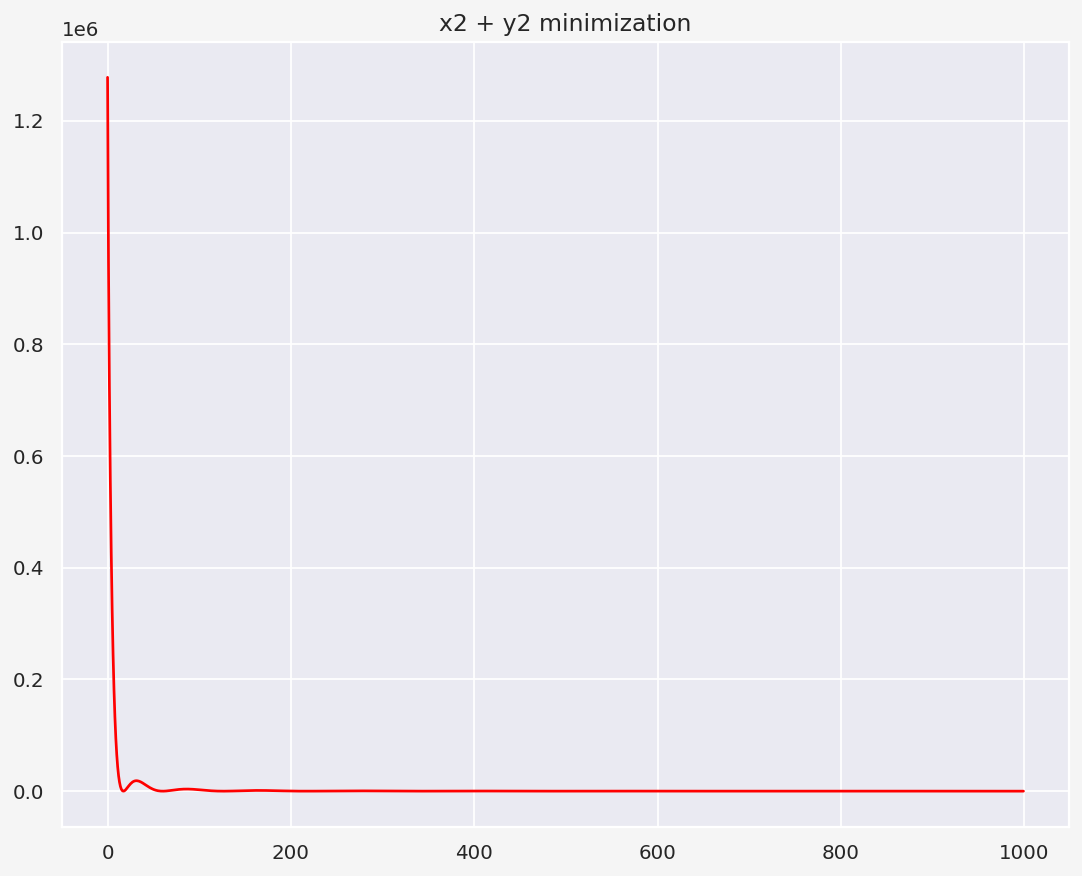

In [8]:
# optim = torch.optim.SGD
optim = STM_Method

start_point = np.array([1000, 1000], dtype=float)
n_iter = 1000
path = func(start_point, optim, iterations=n_iter, lr=1e-2)

values = np.array([sumq(t) for t in path])

with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
    
    plt.figure(figsize=(10, 8), dpi=130, facecolor='whitesmoke')
    plt.plot(np.arange(n_iter), values[1:], color='red')
    plt.title('x2 + y2 minimization', fontsize=13)
    plt.show()
    


### Try with MNIST

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [24]:
train = pd.read_csv('./data/train.csv', dtype=np.float32)
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
targets = train.label.values
features = train.loc[:, train.columns!='label'].values / 255


train_features, validate_features, train_targets, validate_targets = train_test_split(features,
                                                                                      targets,
                                                                                      test_size=0.2,
                                                                                      random_state=42
                                                                                     )

batch_size = 100
iters = 10000
batch_amounts = train_features.shape[0] // batch_size
epochs = iters // batch_amounts


tensor_x_train = torch.from_numpy(train_features)
tensor_y_train = torch.from_numpy(train_targets).type(torch.LongTensor)

tensor_x_val = torch.from_numpy(validate_features)
tensor_y_val = torch.from_numpy(validate_targets).type(torch.LongTensor)

train = TensorDataset(tensor_x_train, tensor_y_train)
validate = TensorDataset(tensor_x_val, tensor_y_val)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate, batch_size=batch_size, shuffle=False)





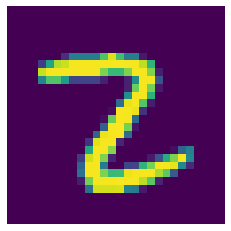

In [26]:
plt.imshow(features[24].reshape(28,28))
plt.axis("off")
plt.show()

In [27]:
class Net(torch.nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, padding=0)
    
        self.relu = torch.nn.ReLU()
        
        self.dropout = torch.nn.Dropout(0.5)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=0)
        
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
    
        self.fc = torch.nn.Linear(32 * 5 * 5, 10)
        
        
    def forward(self, x):
        
        # conv 1
        out = self.conv1(x)
        out = self.relu(out)
    
        # maxpool
        out = self.maxpool(out)
        out = self.dropout(out)
        
        # conv 2
        out = self.conv2(out)
        out = self.relu(out)
        
        # maxpool
        out = self.maxpool(out)
        
        # to linear
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
        

In [37]:
model = Net()
summary(model, (1, 28, 28, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
           Dropout-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 32, 11, 11]           4,640
              ReLU-6           [-1, 32, 11, 11]               0
         MaxPool2d-7             [-1, 32, 5, 5]               0
            Linear-8                   [-1, 10]           8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.05
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


In [29]:
def net_go(loss_func, opt, model, train_loader, validate_loader, epochs : int):

    loss = {'train' : [], 'validate' : []}
    accuracy = []

    for epoch in range(epochs):

        loss_train = []
        acc_train = []

        loss_val = []
        acc_val = []

        start = time.time()

        model.train(True)

        for X_batch, y_batch in train_loader:

            opt.zero_grad()
            
            
            X_batch = Variable(X_batch.view(batch_size, 1, 28, 28))
            X_batch = X_batch.to(device)
            y_batch = Variable(y_batch)
            y_batch = y_batch.to(device)
            
            predicts = model(X_batch)
            error = loss_func(predicts, y_batch)
            
            error.backward()
            opt.step()
            
            loss_train.append(error.item())
        
        model.train(False)
        
        with torch.no_grad():
            
            for X_batch, y_batch in validate_loader:
                
                opt.zero_grad()
                
                X_batch = Variable(X_batch.view(batch_size, 1, 28, 28))  
                X_batch = X_batch.to(device)
                y_batch = Variable(y_batch)
                y_batch = y_batch.to(device)
                
                predicts = model(X_batch)
                error = loss_func(predicts, y_batch)
                
                loss_val.append(error.item())
                
                y_val_batch = predicts.max(1)[1].data
                acc = accuracy_score(y_val_batch, y_batch)
                acc_val.append(acc)
        
        print('{} out of {} epochs,  spend {} seconds'.format(epoch + 1, epochs, round(time.time() - start, 2)))
        
        loss['train'].append(np.mean(loss_train))
        loss['validate'].append(np.mean(loss_val))
        accuracy.append(np.mean(acc_val))
        
        
    return loss, accuracy
        

In [30]:
def print_res(loss, accuracy):
    
    with sns.plotting_context('notebook'), sns.axes_style('darkgrid'):
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        axes[0].set_title('Loss')
        axes[0].plot(loss['train'], label='train loss')
        axes[0].plot(loss['validate'], label='validate loss')
        axes[0].legend()
        
        axes[1].set_title('Accuracy')
        axes[1].plot(accuracy)


In [44]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = STM_Method(model.parameters(), lr=1e-2
model.to(device)

SyntaxError: invalid syntax (<ipython-input-44-7b3ae9b12a99>, line 3)

In [45]:
network_args = {
    'loss_func' : loss_func,
    'opt' : optimizer,
    'model' : model,
    'train_loader' : train_loader,
    'validate_loader' : validate_loader,
    'epochs' : epochs
}

loss, accuracy = net_go(**network_args)

1 out of 29 epochs,  spend 5.87 seconds
2 out of 29 epochs,  spend 6.19 seconds
3 out of 29 epochs,  spend 6.87 seconds
4 out of 29 epochs,  spend 7.0 seconds
5 out of 29 epochs,  spend 5.8 seconds
6 out of 29 epochs,  spend 6.35 seconds
7 out of 29 epochs,  spend 6.19 seconds
8 out of 29 epochs,  spend 6.14 seconds
9 out of 29 epochs,  spend 6.27 seconds
10 out of 29 epochs,  spend 6.23 seconds
11 out of 29 epochs,  spend 6.27 seconds
12 out of 29 epochs,  spend 6.19 seconds
13 out of 29 epochs,  spend 6.2 seconds
14 out of 29 epochs,  spend 6.22 seconds
15 out of 29 epochs,  spend 5.89 seconds
16 out of 29 epochs,  spend 6.21 seconds
17 out of 29 epochs,  spend 6.2 seconds
18 out of 29 epochs,  spend 6.16 seconds
19 out of 29 epochs,  spend 6.19 seconds
20 out of 29 epochs,  spend 6.19 seconds
21 out of 29 epochs,  spend 6.23 seconds
22 out of 29 epochs,  spend 6.2 seconds
23 out of 29 epochs,  spend 6.18 seconds
24 out of 29 epochs,  spend 6.21 seconds
25 out of 29 epochs,  spend 6.

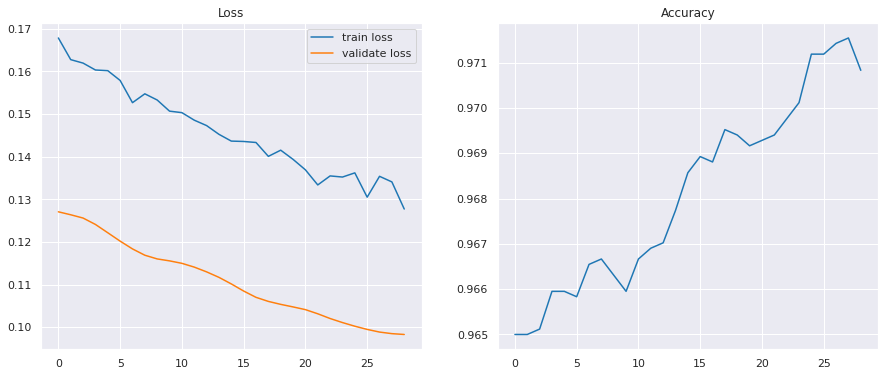

In [46]:
print_res(loss, accuracy)

### Compare with PyTorch Adam

In [34]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=800, out_features=10, bias=True)
)

In [35]:
network_args = {
    'loss_func' : loss_func,
    'opt' : optimizer,
    'model' : model,
    'train_loader' : train_loader,
    'validate_loader' : validate_loader,
    'epochs' : epochs
}

loss, accuracy = net_go(**network_args)

1 out of 29 epochs,  spend 5.59 seconds
2 out of 29 epochs,  spend 5.08 seconds
3 out of 29 epochs,  spend 5.5 seconds
4 out of 29 epochs,  spend 5.4 seconds
5 out of 29 epochs,  spend 6.49 seconds
6 out of 29 epochs,  spend 6.41 seconds
7 out of 29 epochs,  spend 6.15 seconds
8 out of 29 epochs,  spend 6.18 seconds
9 out of 29 epochs,  spend 6.09 seconds
10 out of 29 epochs,  spend 6.26 seconds
11 out of 29 epochs,  spend 6.13 seconds
12 out of 29 epochs,  spend 5.77 seconds
13 out of 29 epochs,  spend 5.33 seconds
14 out of 29 epochs,  spend 5.43 seconds
15 out of 29 epochs,  spend 5.22 seconds
16 out of 29 epochs,  spend 5.57 seconds
17 out of 29 epochs,  spend 5.12 seconds
18 out of 29 epochs,  spend 5.22 seconds
19 out of 29 epochs,  spend 5.33 seconds
20 out of 29 epochs,  spend 5.75 seconds
21 out of 29 epochs,  spend 5.37 seconds
22 out of 29 epochs,  spend 6.44 seconds
23 out of 29 epochs,  spend 6.49 seconds
24 out of 29 epochs,  spend 5.88 seconds
25 out of 29 epochs,  spend

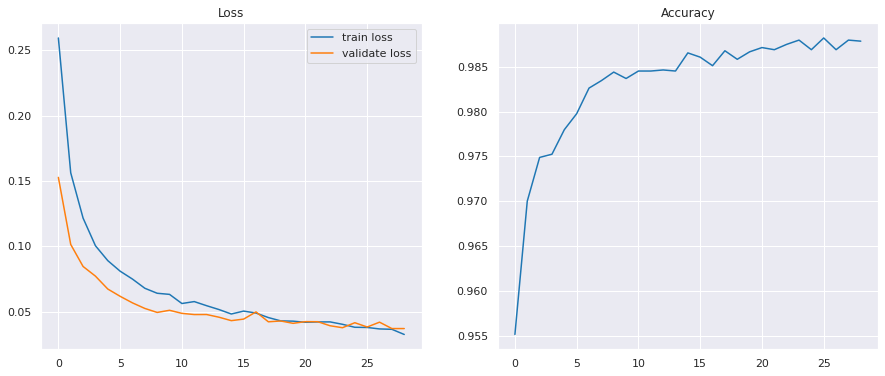

In [36]:
print_res(loss, accuracy)